# Multiple Variables

In [31]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys

In [32]:
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

Our model is a wave, but we observe the full wave and find the posterior distribution for the speed.

In [33]:
pyro.clear_param_store()
def wave(c=1,plot_wave=False):
    """ what are input params  """
    # basic parameters (fixed)
    nx = 21  # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2 / (nx-1)
    nt = 10    #nt is the number of timesteps we want to calculate
    dt = .025  #dt is the amount of time each timestep covers (delta t)

    # initial conditions
    h = torch.ones(nx)     
    h[int(.5 / dx):int(1 / dx + 1)] = 2  # set h = 2 between 0.5 and 1 
    if (plot_wave):
        plt.plot(np.linspace(0, 2, nx), h.numpy());
    
    # get pyro distribution of speed
    speed = pyro.sample("speed", dist.Normal(c, 0.25))

    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(nx)
    for n in range(nt): 
        hn[0] = h[0]
        hn[1:] = h[1:] - speed * dt / dx * (h[1:] - h[0:-1])
        # set h to hn for next iteration
        h = hn
    
    # the final observed h may have some noise
    h = torch.tensor([pyro.sample("h_{}".format(str(i)),dist.Normal(h[i],0.01)) 
                      for i in range(nx)])

    if (plot_wave):
        plt.plot(np.linspace(0, 2, nx), h.numpy());

    return(speed,h)


speed = tensor(0.8313) 
h = tensor([0.9986, 0.9995, 1.0061, 1.0116, 1.0104, 1.0892, 1.3704, 1.6570, 1.8725,
        1.9588, 1.9938, 1.9051, 1.6506, 1.3480, 1.1410, 1.0339, 1.0062, 1.0137,
        0.9913, 0.9988, 0.9941])


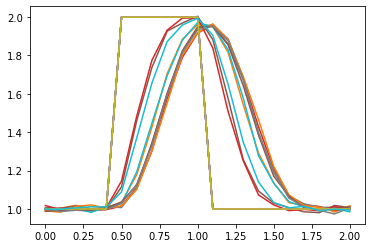

In [34]:
for i in range(10):
    speed,h=wave(plot_wave=True)
print("speed =",speed,"\nh =",h)

In [46]:
uncond = [wave() for i in range(1000)]
speed_uncond,h_uncond = zip(*uncond)

1.0034274


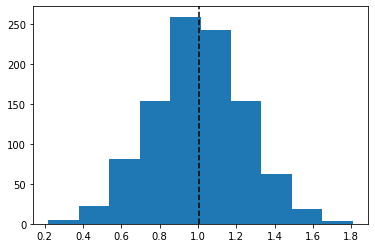

In [47]:
plt.hist(speed_uncond)
plt.axvline(np.mean(speed_uncond),c="k",ls="--")
print(np.mean(speed_uncond))

We observe the wave at a few points around the peak (copy and pasted from an example wave that had speed 0.6828)

In [37]:
observed_h = h
observed_speed = speed
nx = 21
observed_inds = range(nx)
keys = ["h_{}".format(str(i)) for i in observed_inds]
data = dict(zip(keys, observed_h))



In [38]:
print(data)

{'h_0': tensor(0.9986), 'h_1': tensor(0.9995), 'h_2': tensor(1.0061), 'h_3': tensor(1.0116), 'h_4': tensor(1.0104), 'h_5': tensor(1.0892), 'h_6': tensor(1.3704), 'h_7': tensor(1.6570), 'h_8': tensor(1.8725), 'h_9': tensor(1.9588), 'h_10': tensor(1.9938), 'h_11': tensor(1.9051), 'h_12': tensor(1.6506), 'h_13': tensor(1.3480), 'h_14': tensor(1.1410), 'h_15': tensor(1.0339), 'h_16': tensor(1.0062), 'h_17': tensor(1.0137), 'h_18': tensor(0.9913), 'h_19': tensor(0.9988), 'h_20': tensor(0.9941)}


In [39]:
conditioned_wave = pyro.condition(wave, data=data)

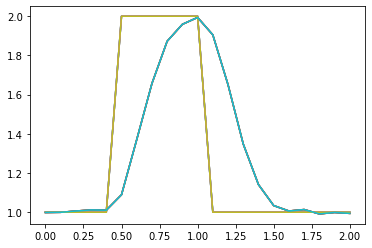

In [40]:
# Check this gives conditioned values fixed
for i in range(5):
    u_observed = conditioned_wave(plot_wave=True)

What if we condition on wave output, can we get the wave speed needed to get this output (using fixed wave speed from before, the correct value should be 0.5)?

Now create the guide, with parameters that should move us towards observed values of the wave.

In [41]:
from torch.distributions import constraints

def wave_parametrized_guide(c=1.,plot_wave=False):
    nx = 21  
    # want to infer speed, and h_i at all values that we don't know them at
    a = pyro.param("a", torch.tensor(c))
    b = pyro.param("b", torch.tensor(1.), 
                   constraint=constraints.positive)

    speed = pyro.sample("speed", dist.Normal(a,b))
    h = torch.zeros(nx)
    observed_inds = range(nx)
    for i in range(nx):
        if (i in observed_inds):
            continue
        c_i = pyro.param("c_{}".format(i),torch.tensor(1.))
        d_i = pyro.param("d_{}".format(i), torch.tensor(1.),
                         constraint=constraints.positive)

        h[i] = (pyro.sample("h_{}".format(str(i)),dist.Normal(c_i,d_i)) )
    if plot_wave:
        h = torch.tensor(h)
        plt.plot(np.linspace(0,2,nx),h.numpy())
    return(speed,h)



/anaconda3/envs/infolab/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor(2.3847, grad_fn=<AddBackward0>),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

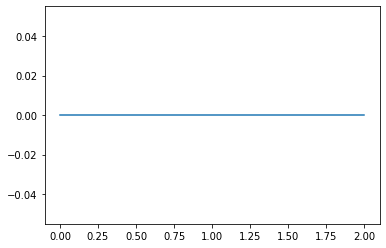

In [42]:
pyro.clear_param_store()
wave_parametrized_guide(plot_wave=True)

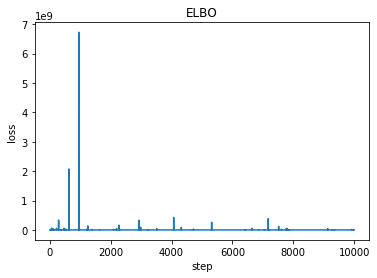

In [43]:
from pyro.optim import Adam
pyro.clear_param_store()
#optimizer = pyro.optim.SGD({"lr": 0.001, "momentum":0.1})
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_wave, 
                     guide=wave_parametrized_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

losses, a,b  = [], [], []
num_steps = 10000
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");


a =  1.2192859649658203
b =  0.8026464581489563


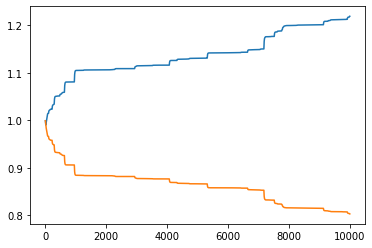

In [44]:
print("a = ",pyro.param("a").item())
print("b = ", pyro.param("b").item())

plt.plot(a);
plt.plot(b);


In [45]:
for i in range(4):
    print("c_{} = ".format(str(i)),pyro.param("c_{}".format(str(i))).item())

KeyError: 'c_0'

In [ ]:
param_store = pyro.get_param_store()
print(param_store.keys())
print(param_store['a'])
print(param_store['b'])

In [ ]:
observed_speed

In [ ]:
speed,h=wave_parametrized_guide()

In [ ]:
plt.plot(torch.tensor(h).numpy())


In [ ]:
plt.plot(observed_inds,observed_h) 